### European Data.

As stated previously, this data is used to predict the values of certain crops using regression models. This 'scenario' is across the entirety of Europe of which we saw a bit of data about from the global dataset (The change in value over time in Western Europe).

Initial EDA was mainly cleaning the dataset so it contained only relevant columns to predicting the Value output. This includes the removal of certain columns like Flags and Footnotes as they had little to no correlation to the data and didn't provide much use as a resource. One difficult step was filtering out what countries were in the dataset and not just their regions. This is because the regional data was already included as a total in the country so having the regional data would potentially confuse the results. The year was also needed to be converted into a date time unit as it was originally a string.

My very first EDA steps were to see a correlated heatmap of the dataset but not including the countries. This ended with a poor regression score that also happened in the global data. Upon realising this I included a dummified dataset of all the countries in the dataset and also the crops. This provided scores that were over 10 times better.

I used regression models to predict value of crops based upon their type and their country. What showed was that the the coefficients showed both a positive and negative impact on the scores. After regularization with ridge and lasso models, there showed a greater positive impact on the scores as well as a much greater negative impact from particular countries.

In [1]:
import warnings
warnings.filterwarnings('ignore')

Below is a dictionary containing the columns that were used in the models.

#### Import the dataset and clean.

In [86]:
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNet, ElasticNetCV
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [3]:
sns.set(rc={'figure.figsize':(40,10),
           'font.size':20})

In [4]:
# europe data + dict

eur = pd.read_csv('./europe.csv', sep=',', quotechar='"', encoding='latin1')
eur_dict = pd.read_csv('./euro.csv')

In [5]:
eur = eur.drop('Flag and Footnotes', axis=1)

In [6]:
eur = eur.rename(columns={'STRUCPRO':'Type'})

In [7]:
eur.head(2)

,TIME,GEO,CROPS,Type,Value
0,2009,"European Union (EU6-1972, EU9-1980, EU10-1985,...",Cereals for the production of grain (including...,Area (cultivation/harvested/production) (1000 ha),"58,935.04"
1,2009,"European Union (EU6-1972, EU9-1980, EU10-1985,...",Dry pulses and protein crops for the productio...,Area (cultivation/harvested/production) (1000 ha),"1,312.44"


#### Converting the Time column to date time data that is now called Year to make more sense.

In [8]:
eur['year'] = pd.to_datetime(eur['TIME']).dt.year
eur.drop('TIME', inplace=True, axis=1)

In [9]:
eur.head()

,GEO,CROPS,Type,Value,year
0,"European Union (EU6-1972, EU9-1980, EU10-1985,...",Cereals for the production of grain (including...,Area (cultivation/harvested/production) (1000 ha),"58,935.04",1970
1,"European Union (EU6-1972, EU9-1980, EU10-1985,...",Dry pulses and protein crops for the productio...,Area (cultivation/harvested/production) (1000 ha),"1,312.44",1970
2,"European Union (EU6-1972, EU9-1980, EU10-1985,...",Permanent grassland,Area (cultivation/harvested/production) (1000 ha),:,1970
3,European Union (current composition),Cereals for the production of grain (including...,Area (cultivation/harvested/production) (1000 ha),"59,494.60",1970
4,European Union (current composition),Dry pulses and protein crops for the productio...,Area (cultivation/harvested/production) (1000 ha),"1,315.46",1970


In [10]:
eur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18810 entries, 0 to 18809
Data columns (total 5 columns):
GEO      18810 non-null object
CROPS    18810 non-null object
Type     18810 non-null object
Value    18810 non-null object
year     18810 non-null int64
dtypes: int64(1), object(4)
memory usage: 734.8+ KB


In [11]:
eur.describe(include='all')

,GEO,CROPS,Type,Value,year
count,18810,18810,18810,18810,18810.0
unique,545,3,1,3605,NaN
top,Extra-Regio NUTS 2,Cereals for the production of grain (including...,Area (cultivation/harvested/production) (1000 ha),:,NaN
freq,810,6270,18810,12602,NaN
mean,NaN,NaN,NaN,NaN,1970.0
std,NaN,NaN,NaN,NaN,0.0
min,NaN,NaN,NaN,NaN,1970.0
25%,NaN,NaN,NaN,NaN,1970.0
50%,NaN,NaN,NaN,NaN,1970.0
75%,NaN,NaN,NaN,NaN,1970.0


In [12]:
eur = eur[eur['Value'] != ':']

In [13]:
eur.describe(include='all')

,GEO,CROPS,Type,Value,year
count,6208,6208,6208,6208,6208.0
unique,467,2,1,3604,NaN
top,Malta,Cereals for the production of grain (including...,Area (cultivation/harvested/production) (1000 ha),0.00,NaN
freq,60,3132,6208,394,NaN
mean,NaN,NaN,NaN,NaN,1970.0
std,NaN,NaN,NaN,NaN,0.0
min,NaN,NaN,NaN,NaN,1970.0
25%,NaN,NaN,NaN,NaN,1970.0
50%,NaN,NaN,NaN,NaN,1970.0
75%,NaN,NaN,NaN,NaN,1970.0


In [14]:
eur.GEO.unique()

array(['European Union (EU6-1972, EU9-1980, EU10-1985, EU12-1994, EU15-2004, EU25-2006, EU27-2013, EU28)',
       'European Union (current composition)', 'Belgium',
       'Région de Bruxelles-Capitale / Brussels Hoofdstedelijk Gewest',
       'Vlaams Gewest', 'Prov. Antwerpen', 'Prov. Limburg (BE)',
       'Prov. Oost-Vlaanderen', 'Prov. Vlaams-Brabant',
       'Prov. West-Vlaanderen', 'Région wallonne', 'Prov. Brabant Wallon',
       'Prov. Hainaut', 'Prov. Liège', 'Prov. Luxembourg (BE)',
       'Prov. Namur', 'Bulgaria', 'Czechia', 'Ceská republika', 'Praha',
       'Strední Cechy', 'Jihozápad', 'Severozápad', 'Severovýchod',
       'Jihovýchod', 'Strední Morava', 'Moravskoslezsko', 'Denmark',
       'Danmark', 'Hovedstaden', 'Sjælland', 'Syddanmark', 'Midtjylland',
       'Nordjylland', 'Germany (until 1990 former territory of the FRG)',
       'Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
 

In [15]:
eur.CROPS.unique()

array(['Cereals for the production of grain (including seed)',
       'Dry pulses and protein crops for the production of grain (including seed and mixtures of cereals and pulses)'],
      dtype=object)

#### Filtering out the regions from the dataset to have mainly countries from the data.

In [16]:
crop_eur = eur[(eur['GEO'] == 'Belgium') | (eur['GEO'] == 'Bulgaria') |
               (eur['GEO'] == 'Denmark') | (eur['GEO'] == 'Czechia') | (eur['GEO'] == 'Germany') |
              (eur['GEO'] == 'Estoni') | (eur['GEO'] == 'Ireland') | (eur['GEO'] == 'Greece') |
              (eur['GEO'] == 'Spain') | (eur['GEO'] == 'France') | (eur['GEO'] == 'Croatia') |
              (eur['GEO'] == 'Italy') | (eur['GEO'] == 'Latvia') | (eur['GEO'] == 'Lithuania')|
              (eur['GEO'] == 'Austria') | (eur['GEO'] == 'Poland') | (eur['GEO'] == 'Portugal')|
              (eur['GEO'] == 'Romania') | (eur['GEO'] == 'Slovenia') | (eur['GEO'] == 'Sweden') |
              (eur['GEO'] == 'United Kingdom') | (eur['GEO'] == 'Iceland') | (eur['GEO'] == 'Switzerland') |
              (eur['GEO'] == 'Albania') | (eur['GEO'] == 'Latvia') | (eur['GEO'] == 'Lithuania') |
              (eur['GEO'] == 'Luxemburg') | (eur['GEO'] == 'Hungary') | (eur['GEO'] == 'Netherlands') |
              (eur['GEO'] == 'Albania')] 

In [17]:
crop_eur.drop('Type', inplace=True, axis = 1)

In [18]:
crop_eur

,GEO,CROPS,Value,year
6,Belgium,Cereals for the production of grain (including...,345.00,1970
7,Belgium,Dry pulses and protein crops for the productio...,1.70,1970
57,Bulgaria,Cereals for the production of grain (including...,"1,829.00",1970
58,Bulgaria,Dry pulses and protein crops for the productio...,2.70,1970
93,Czechia,Cereals for the production of grain (including...,"1,541.70",1970
94,Czechia,Dry pulses and protein crops for the productio...,29.00,1970
129,Denmark,Cereals for the production of grain (including...,"1,487.70",1970
130,Denmark,Dry pulses and protein crops for the productio...,6.80,1970
342,Ireland,Cereals for the production of grain (including...,298.47,1970
343,Ireland,Dry pulses and protein crops for the productio...,4.19,1970


In [19]:
eur_dict

,Unnamed: 0,Unnamed: 1
0,Geo,The country of which the crop was harvested fr...
1,Time,The year of which the crop was harvested to se...
2,Crops,This is one of three different ‘crops’; Grassl...
3,Value,The amount of the crop harvested in the type.
4,Type,The type in which the value was harvested. Thi...


#### The Value is actually a string so needs to be converted to a float.

In [20]:
euro = crop_eur.Value.map(lambda x: x.replace(',', ''))

In [21]:
euro = euro.map(lambda x: x.replace('.', ''))


In [22]:
euro_column = euro.map(lambda x: float(x))

In [23]:
euro_column

6         34500.0
7           170.0
57       182900.0
58          270.0
93       154170.0
94         2900.0
129      148770.0
130         680.0
342       29847.0
343         419.0
369      126130.0
370        2098.0
465      607330.0
466       31110.0
552      938120.0
553       21620.0
801       55956.0
802         302.0
819      345370.0
820        7470.0
954       54080.0
955         250.0
966      110350.0
967        4770.0
996      288210.0
997        2040.0
1056      22840.0
1057        320.0
1113      83510.0
1114       2160.0
           ...   
16936       385.0
17022    133906.0
17023      3515.0
17058    141355.0
17059      3163.0
17271     26025.0
17272       848.0
17298     84423.0
17299     12303.0
17394    601477.0
17395     48301.0
17481    907191.0
17730     46260.0
17731       259.0
17748    315257.0
17895    127030.0
17896     20600.0
17925    239010.0
17926      1837.0
18042     77894.0
18043      2063.0
18192     22619.0
18193      2099.0
18231    519896.0
18232     

In [24]:
euro_column = euro_column/100

In [25]:
euro_column

6         345.00
7           1.70
57       1829.00
58          2.70
93       1541.70
94         29.00
129      1487.70
130         6.80
342       298.47
343         4.19
369      1261.30
370        20.98
465      6073.30
466       311.10
552      9381.20
553       216.20
801       559.56
802         3.02
819      3453.70
820        74.70
954       540.80
955         2.50
966      1103.50
967        47.70
996      2882.10
997        20.40
1056      228.40
1057        3.20
1113      835.10
1114       21.60
          ...   
16936       3.85
17022    1339.06
17023      35.15
17058    1413.55
17059      31.63
17271     260.25
17272       8.48
17298     844.23
17299     123.03
17394    6014.77
17395     483.01
17481    9071.91
17730     462.60
17731       2.59
17748    3152.57
17895    1270.30
17896     206.00
17925    2390.10
17926      18.37
18042     778.94
18043      20.63
18192     226.19
18193      20.99
18231    5198.96
18232     144.78
18363     919.83
18588       1.00
18589       0.

In [26]:
eur['value'] = euro_column
eur

,GEO,CROPS,Type,Value,year,value
0,"European Union (EU6-1972, EU9-1980, EU10-1985,...",Cereals for the production of grain (including...,Area (cultivation/harvested/production) (1000 ha),"58,935.04",1970,NaN
1,"European Union (EU6-1972, EU9-1980, EU10-1985,...",Dry pulses and protein crops for the productio...,Area (cultivation/harvested/production) (1000 ha),"1,312.44",1970,NaN
3,European Union (current composition),Cereals for the production of grain (including...,Area (cultivation/harvested/production) (1000 ha),"59,494.60",1970,NaN
4,European Union (current composition),Dry pulses and protein crops for the productio...,Area (cultivation/harvested/production) (1000 ha),"1,315.46",1970,NaN
6,Belgium,Cereals for the production of grain (including...,Area (cultivation/harvested/production) (1000 ha),345.00,1970,345.00
7,Belgium,Dry pulses and protein crops for the productio...,Area (cultivation/harvested/production) (1000 ha),1.70,1970,1.70
9,Région de Bruxelles-Capitale / Brussels Hoofds...,Cereals for the production of grain (including...,Area (cultivation/harvested/production) (1000 ha),0.10,1970,NaN
10,Région de Bruxelles-Capitale / Brussels Hoofds...,Dry pulses and protein crops for the productio...,Area (cultivation/harvested/production) (1000 ha),0.00,1970,NaN
12,Région de Bruxelles-Capitale / Brussels Hoofds...,Cereals for the production of grain (including...,Area (cultivation/harvested/production) (1000 ha),0.10,1970,NaN
13,Région de Bruxelles-Capitale / Brussels Hoofds...,Dry pulses and protein crops for the productio...,Area (cultivation/harvested/production) (1000 ha),0.00,1970,NaN


In [27]:
eur.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6208 entries, 0 to 18655
Data columns (total 6 columns):
GEO      6208 non-null object
CROPS    6208 non-null object
Type     6208 non-null object
Value    6208 non-null object
year     6208 non-null int64
value    448 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 339.5+ KB


In [28]:
eur.describe(include='all')

,GEO,CROPS,Type,Value,year,value
count,6208,6208,6208,6208,6208.0,448.000000
unique,467,2,1,3604,NaN,NaN
top,Malta,Cereals for the production of grain (including...,Area (cultivation/harvested/production) (1000 ha),0.00,NaN,NaN
freq,60,3132,6208,394,NaN,NaN
mean,NaN,NaN,NaN,NaN,1970.0,1088.876674
std,NaN,NaN,NaN,NaN,0.0,2078.750612
min,NaN,NaN,NaN,NaN,1970.0,0.000000
25%,NaN,NaN,NaN,NaN,1970.0,19.585000
50%,NaN,NaN,NaN,NaN,1970.0,176.030000
75%,NaN,NaN,NaN,NaN,1970.0,1013.827500


In [29]:
eur.dropna(inplace=True)

#### Showing a histogram of the countries and their value output.

In [30]:
cou = eur.groupby('GEO')['value'].mean()

In [31]:
cou = pd.DataFrame(cou)

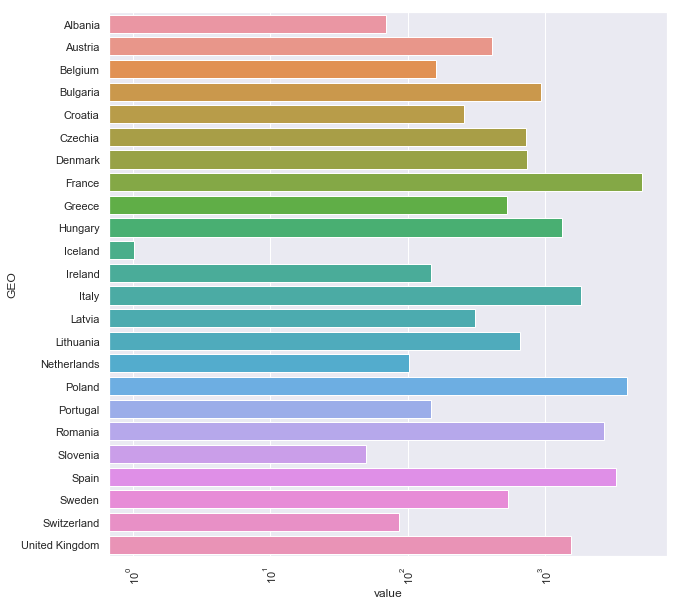

In [32]:
plt.figure(figsize=(10,10))

country_graph = sns.barplot(y='GEO', x='value', data=cou.reset_index(), orient='h', )
country_graph.set(xscale='log')
plt.xticks(rotation=90);

In [33]:
eur.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448 entries, 6 to 18622
Data columns (total 6 columns):
GEO      448 non-null object
CROPS    448 non-null object
Type     448 non-null object
Value    448 non-null object
year     448 non-null int64
value    448 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 24.5+ KB


#### Dummify the countries and the crops.

In [34]:
dum = pd.get_dummies(eur[['GEO', 'CROPS']], drop_first=True)

In [35]:
dum['value'] = eur['value']

In [36]:
dum['year'] = eur['year']


In [37]:
eur_ = dum

In [38]:

eur_X = eur_
eur_y = eur_.pop('value')


In [39]:
eur_X

,GEO_Austria,GEO_Belgium,GEO_Bulgaria,GEO_Croatia,GEO_Czechia,GEO_Denmark,GEO_France,GEO_Greece,GEO_Hungary,GEO_Iceland,...,GEO_Poland,GEO_Portugal,GEO_Romania,GEO_Slovenia,GEO_Spain,GEO_Sweden,GEO_Switzerland,GEO_United Kingdom,CROPS_Dry pulses and protein crops for the production of grain (including seed and mixtures of cereals and pulses),year
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1970
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1970
57,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1970
58,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1970
93,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1970
94,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1970
129,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1970
130,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1970
342,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1970
343,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1970


#### Start with a train test split.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(eur_X, eur_y, test_size=0.33)

In [43]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=eur_X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=eur_X.columns)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
scaler = StandardScaler()

#### Create a function that saves time on  builing a regression model to run.

In [44]:
# Defined function
def get_model_scores(model, X_train, y_train, X_test, y_test):
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print("Cross-validated training scores:", scores)
    print("Mean cross-validated training score:", scores.mean())
    model.fit(X_train, y_train)
    print("Training Score:", model.score(X_train, y_train))
    print("Test Score:", model.score(X_test, y_test))
    return model

#### Running the model and getting the coefficients displayed.

In [45]:
get_model_scores(LinearRegression(), X_train, y_train, X_test, y_test)

Cross-validated training scores: [0.66554813 0.7035541  0.52640665 0.59756232 0.73330011]
Mean cross-validated training score: 0.6452742609749604
Training Score: 0.6953999523823395
Test Score: 0.47496335781539867


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [46]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [47]:
df_coef1 = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
df_coef1['coef_abs'] = df_coef1.coefficients.abs()
df_coef1

,coefficients,coef_abs
GEO_Austria,28.304533,28.304533
GEO_Belgium,-10.623005,10.623005
GEO_Bulgaria,133.678626,133.678626
GEO_Croatia,-1.298663,1.298663
GEO_Czechia,98.557785,98.557785
GEO_Denmark,103.237058,103.237058
GEO_France,1078.764581,1078.764581
GEO_Greece,107.848732,107.848732
GEO_Hungary,222.726668,222.726668
GEO_Iceland,-8.886006,8.886006


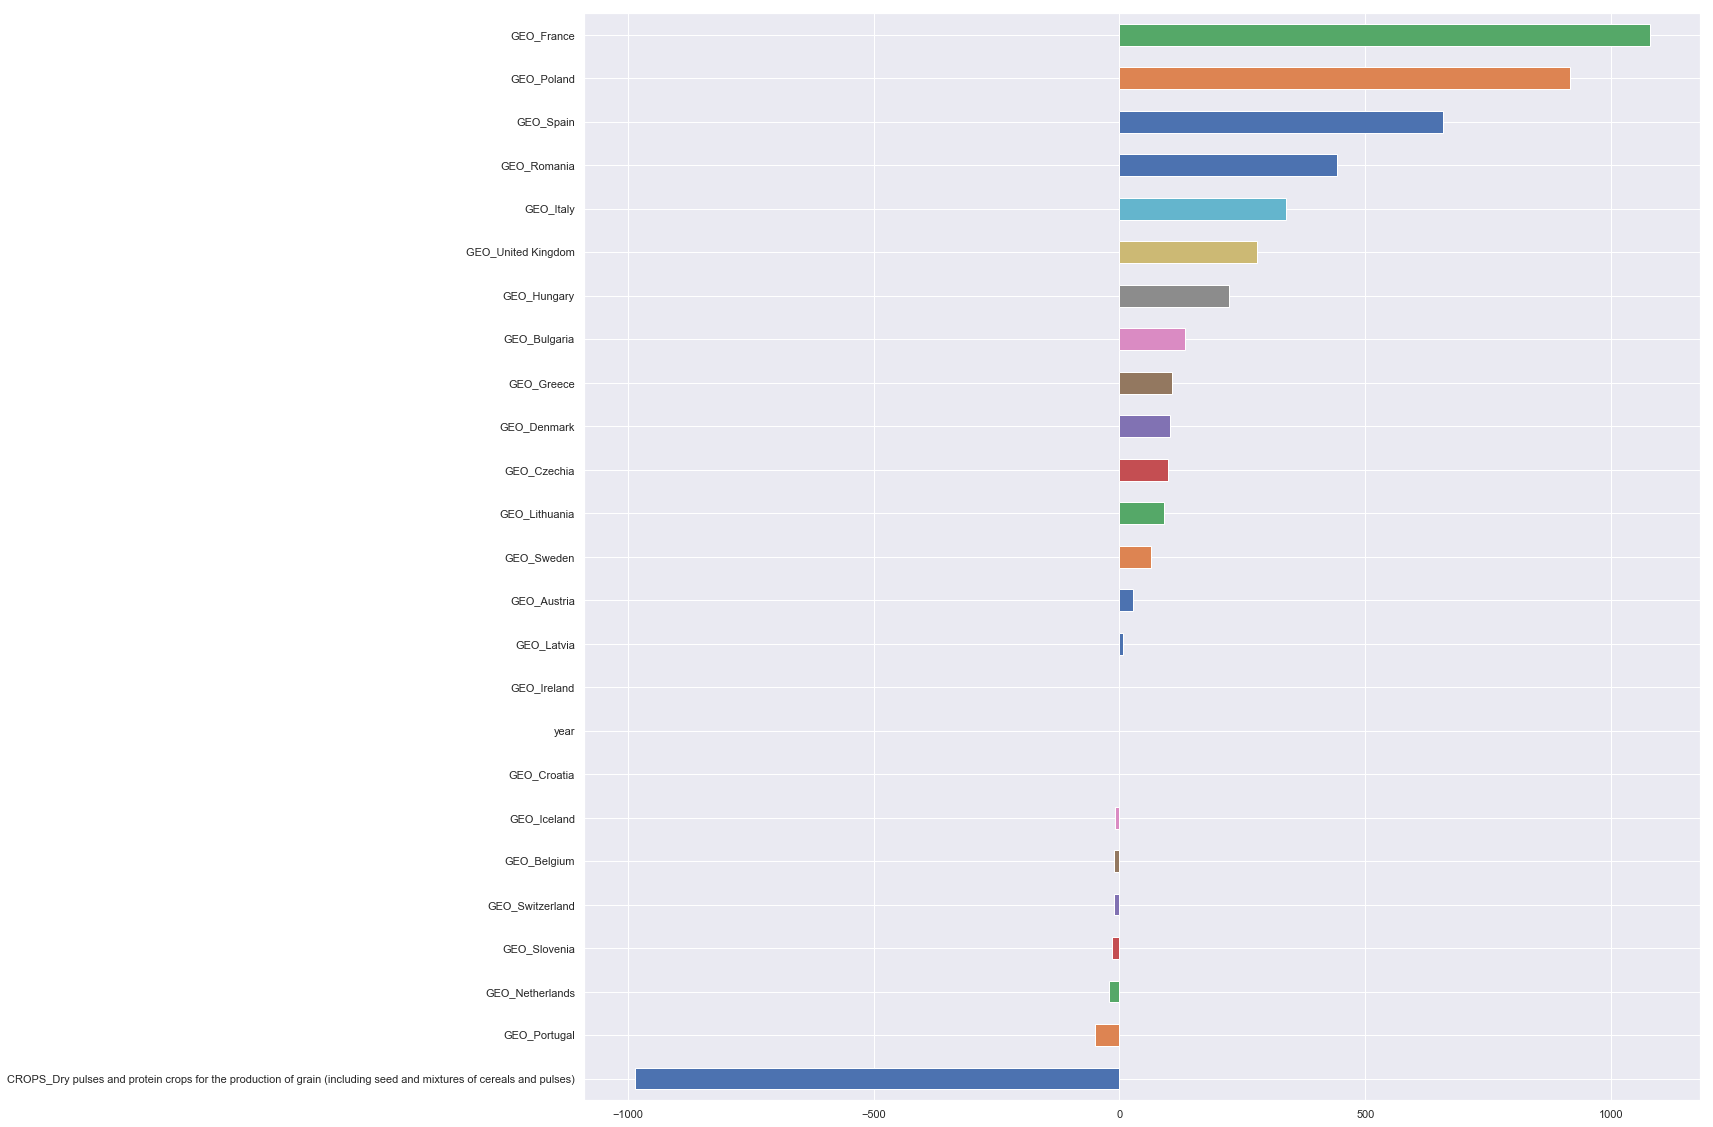

In [124]:
plt.figure(figsize=(20,20))

df_coef1['coefficients'].sort_values().plot(kind='barh');

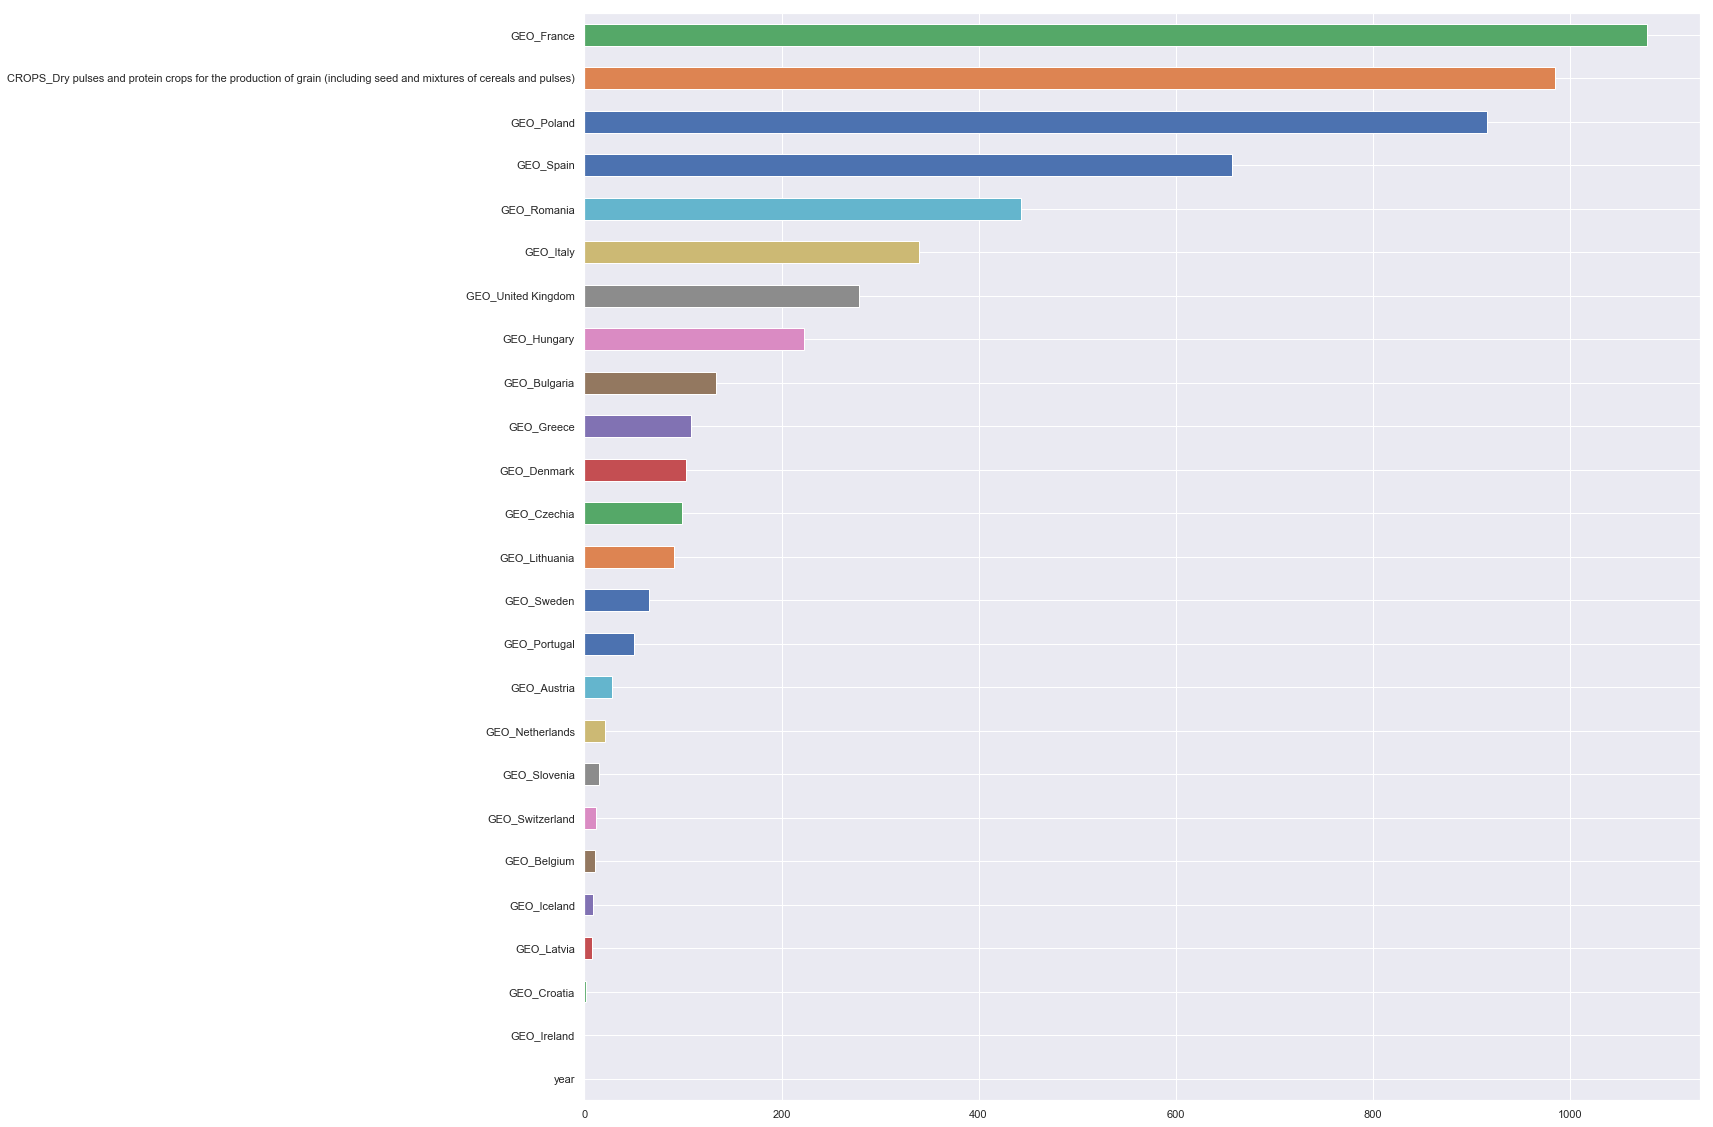

In [133]:
plt.figure(figsize=(20,20))
df_coef1['coef_abs'].sort_values().plot(kind='barh');

### Now testing with regulization to see if there are different results.

In [50]:
get_model_scores(RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5), X_train, y_train, X_test, y_test)

Cross-validated training scores: [0.66552516 0.69606145 0.53019891 0.60217383 0.70911351]
Mean cross-validated training score: 0.6406145732679944
Training Score: 0.6950237141230067
Test Score: 0.47771133227447005


RidgeCV(alphas=array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [51]:
model = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
model.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [52]:
df_coef2 = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
df_coef2['coef_abs'] = df_coef2.coefficients.abs()
df_coef2

,coefficients,coef_abs
GEO_Austria,-28.916470,28.916470
GEO_Belgium,-64.202625,64.202625
GEO_Bulgaria,85.051206,85.051206
GEO_Croatia,-56.641565,56.641565
GEO_Czechia,45.996969,45.996969
GEO_Denmark,47.194682,47.194682
GEO_France,1015.858107,1015.858107
GEO_Greece,54.515532,54.515532
GEO_Hungary,170.899292,170.899292
GEO_Iceland,-58.909293,58.909293


#### There is a clear difference in the impact that some columns now have on the Value output.

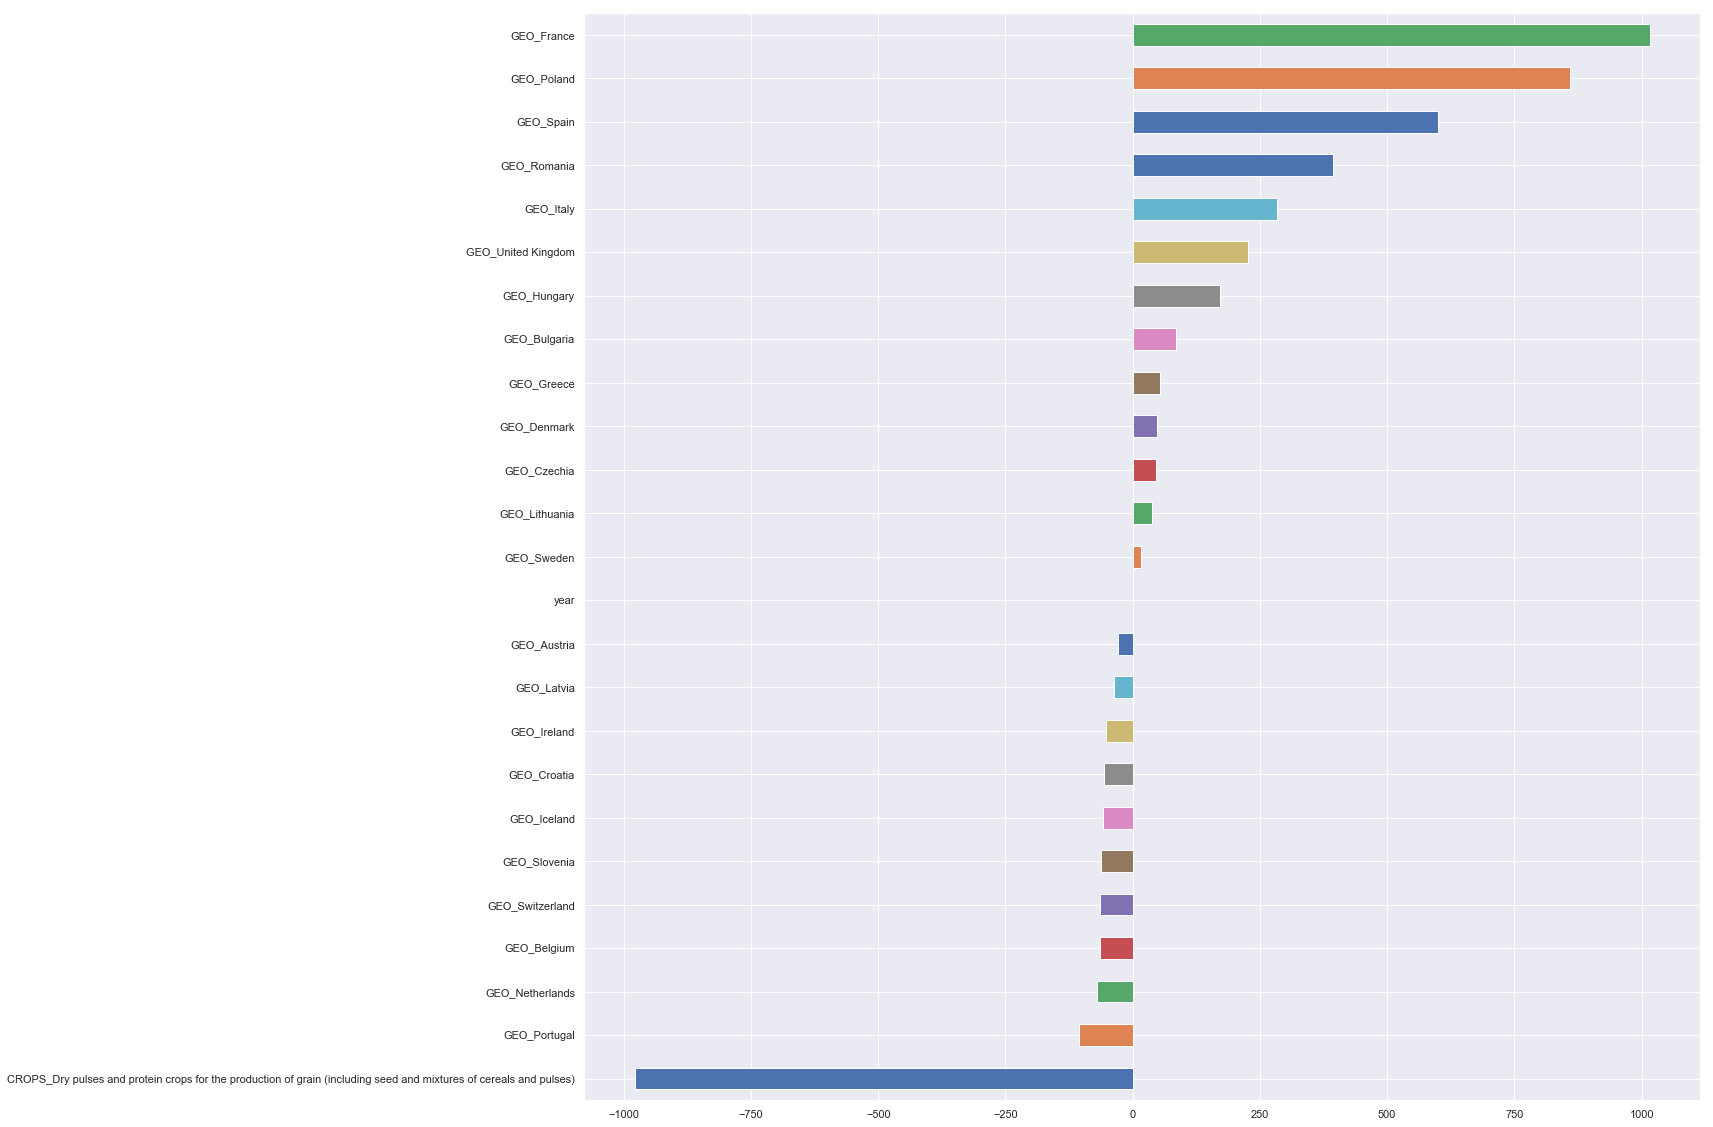

In [53]:
plt.figure(figsize=(20,20))
df_coef2['coefficients'].sort_values().plot(kind='barh');

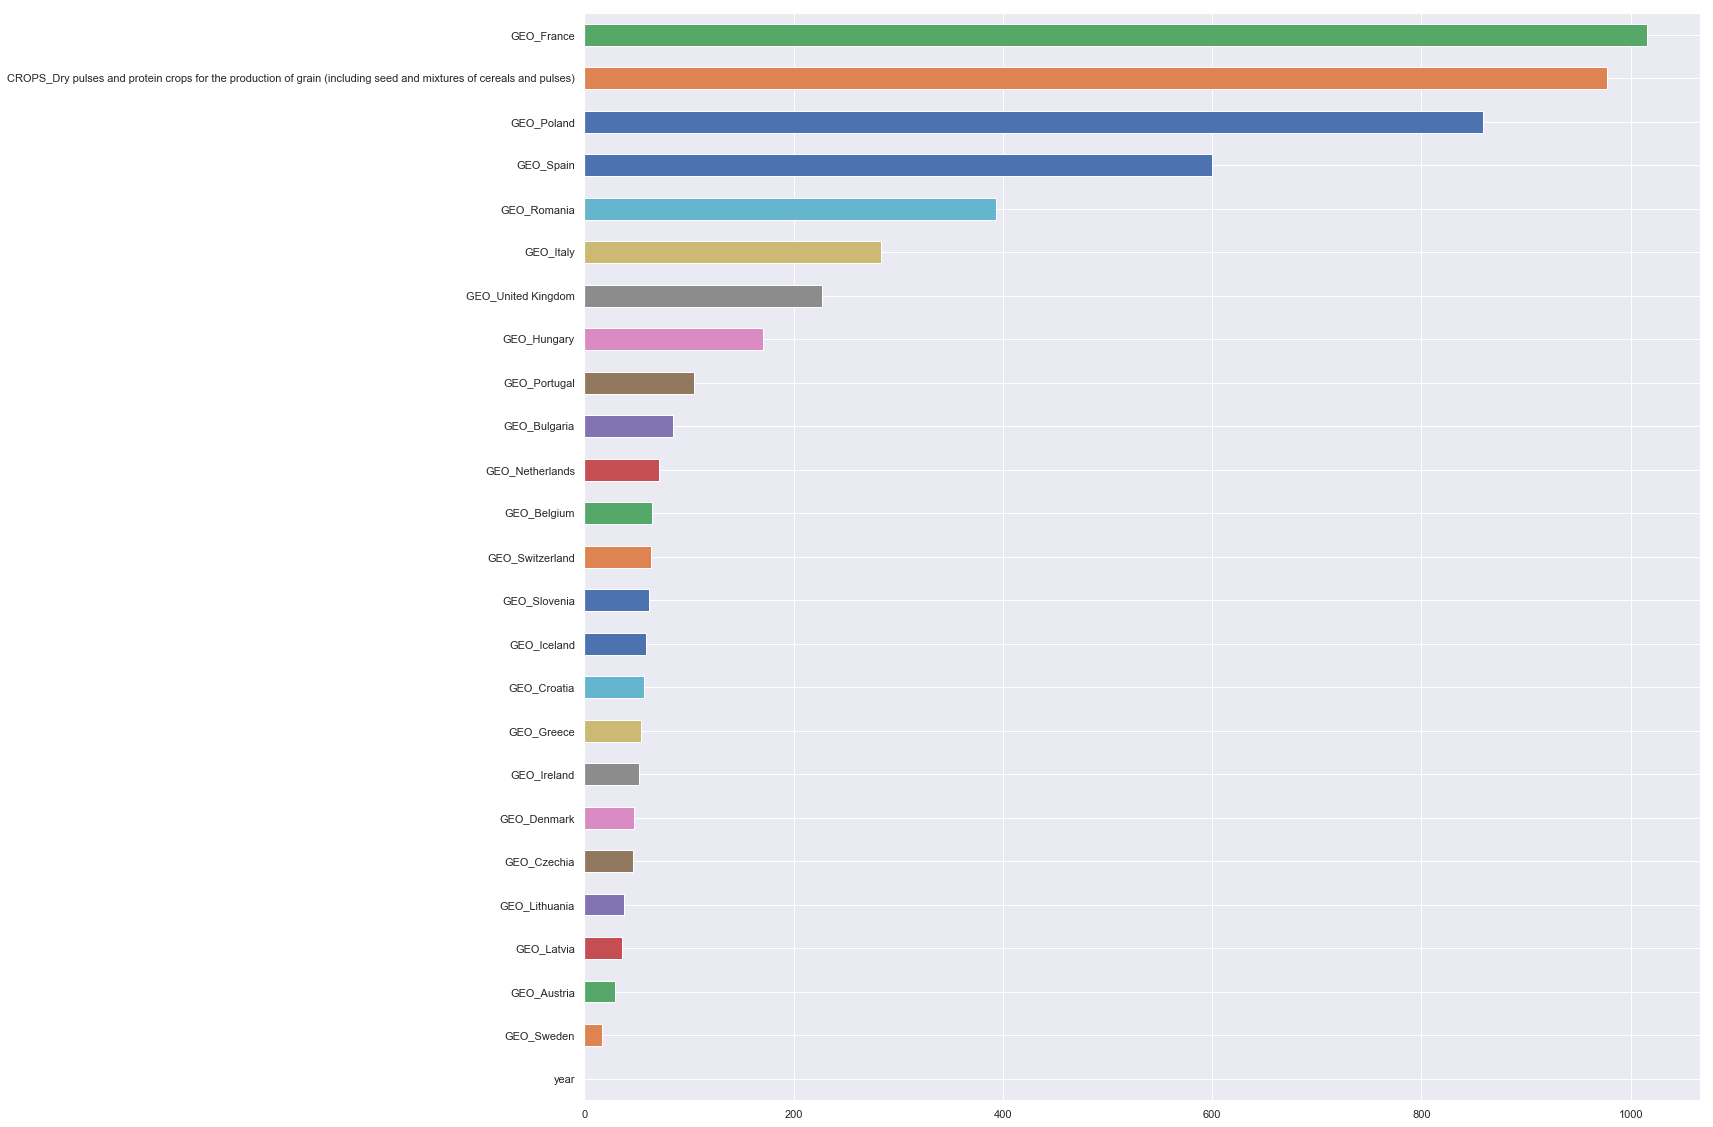

In [54]:
plt.figure(figsize=(20,20))
df_coef2['coef_abs'].sort_values().plot(kind='barh');

In [55]:
get_model_scores(LassoCV(alphas=np.logspace(-4, 4, 10), cv=5), X_train, y_train, X_test, y_test)

Cross-validated training scores: [0.66526223 0.70428517 0.52720863 0.60084617 0.73157579]
Mean cross-validated training score: 0.645835598220018
Training Score: 0.6952963284746012
Test Score: 0.4762945905522594


LassoCV(alphas=array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [56]:
model = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
model.fit(X_train, y_train)

LassoCV(alphas=array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [57]:
df_coef3 = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
df_coef3['coef_abs'] = df_coef3.coefficients.abs()
df_coef3

,coefficients,coef_abs
GEO_Austria,0.000000,0.000000
GEO_Belgium,-32.956029,32.956029
GEO_Bulgaria,108.838251,108.838251
GEO_Croatia,-24.437446,24.437446
GEO_Czechia,71.816947,71.816947
GEO_Denmark,74.875678,74.875678
GEO_France,1051.201978,1051.201978
GEO_Greece,80.932193,80.932193
GEO_Hungary,196.863074,196.863074
GEO_Iceland,-29.468909,29.468909


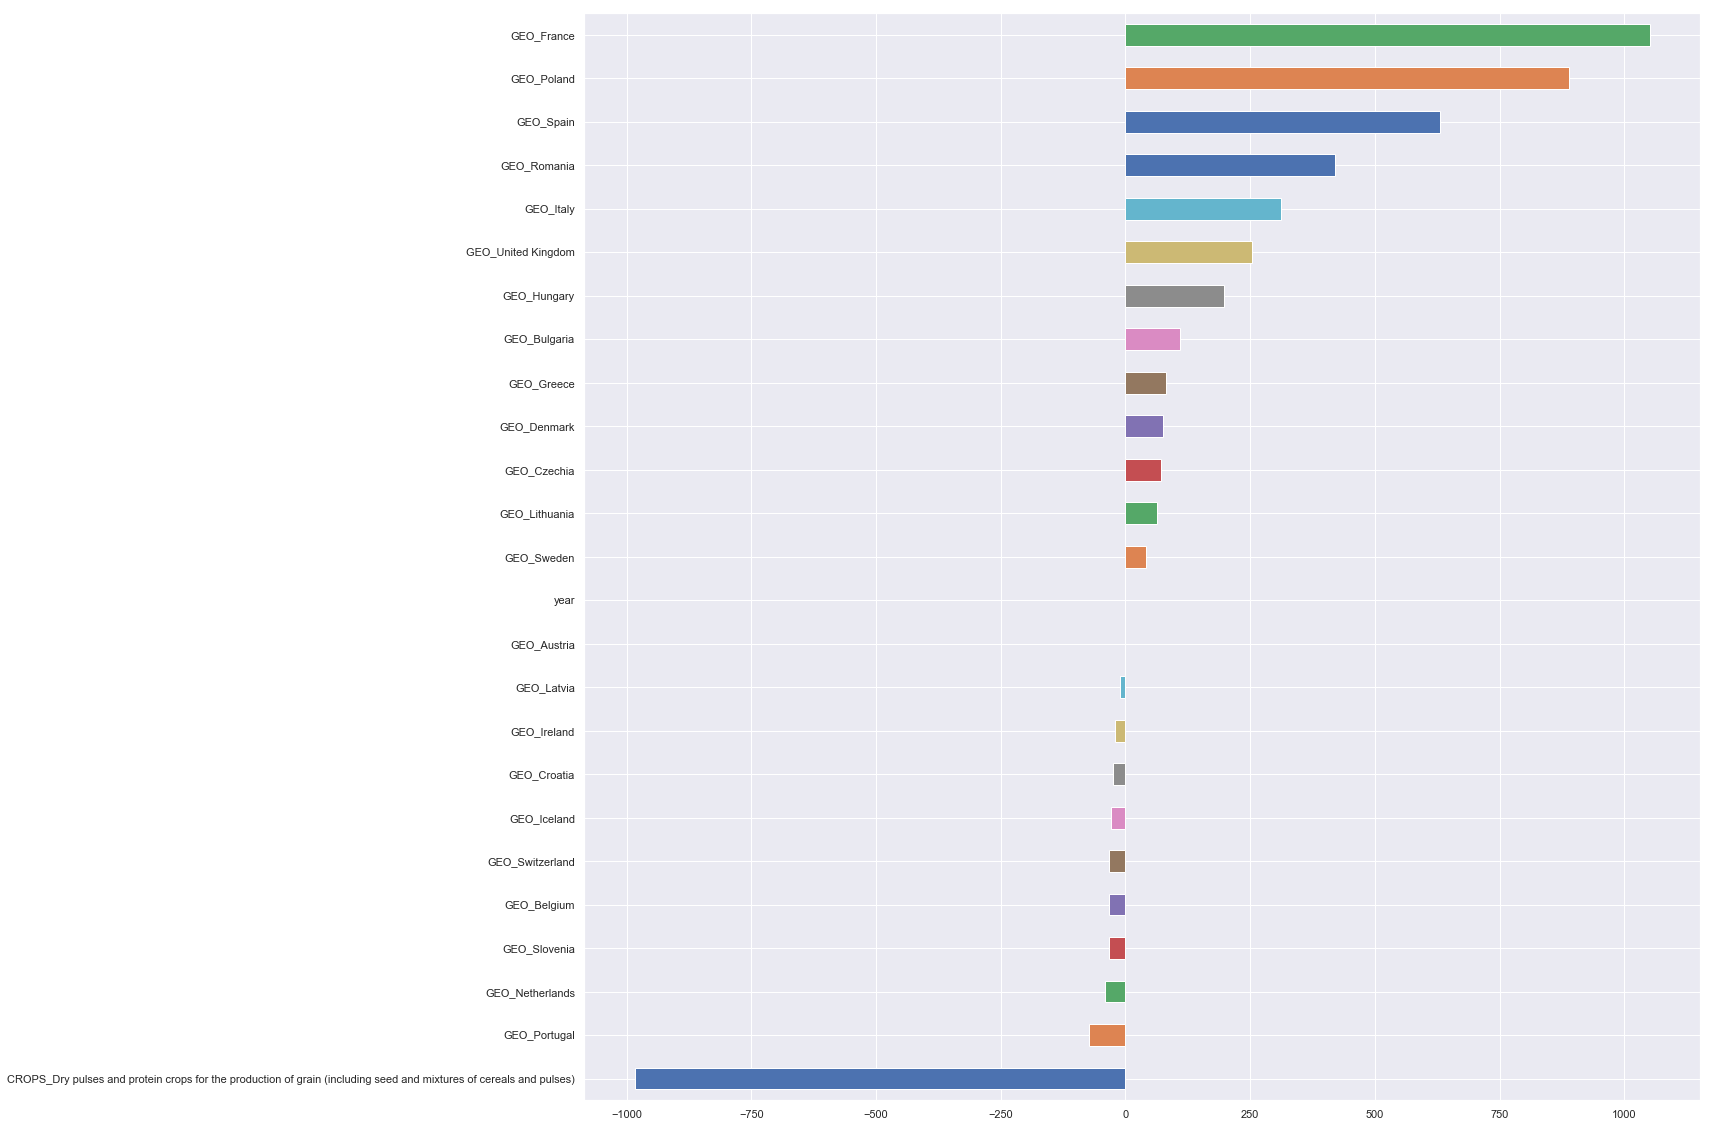

In [58]:
plt.figure(figsize=(20,20))

df_coef3['coefficients'].sort_values().plot(kind='barh');

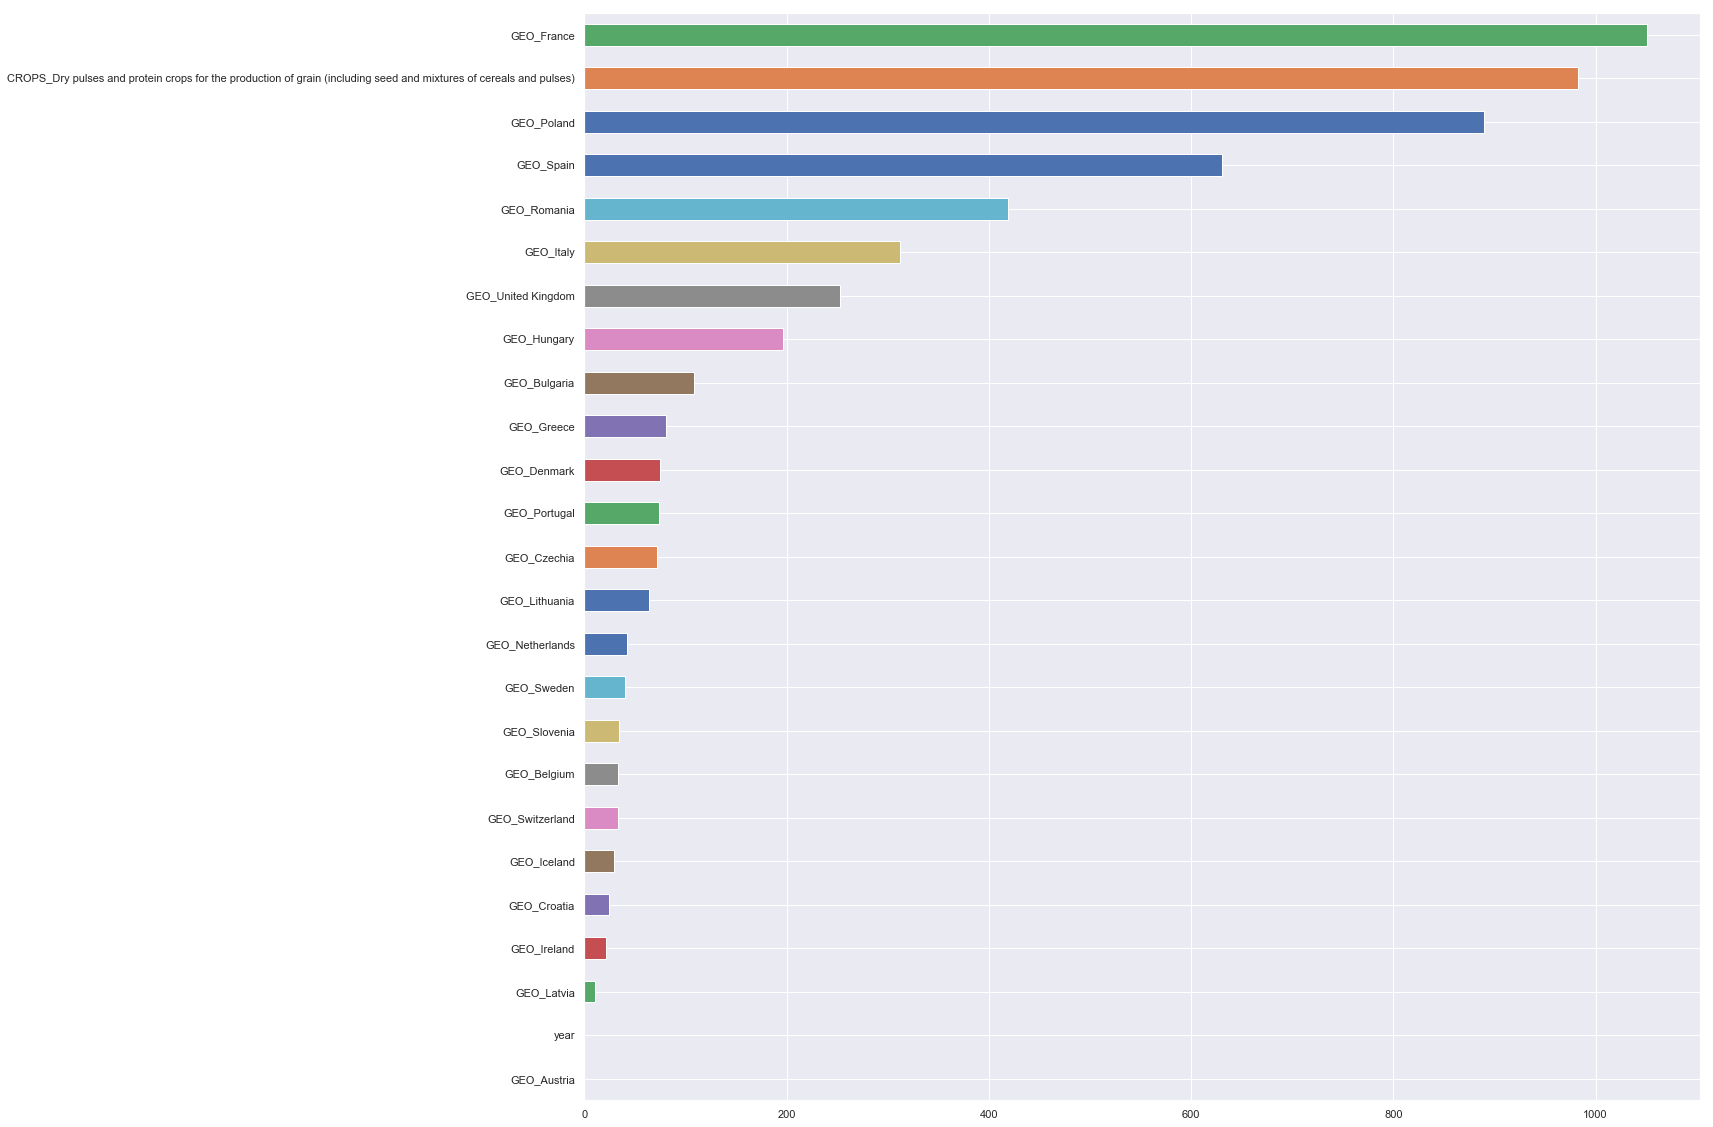

In [59]:
plt.figure(figsize=(20,20))

df_coef3['coef_abs'].sort_values().plot(kind='barh');

In [60]:
elastic = ElasticNetCV(alphas=np.logspace(-4, 4, 10), cv=5)

In [61]:
get_model_scores(elastic, X_train, y_train, X_test, y_test)

Cross-validated training scores: [0.66550181 0.70059702 0.53328905 0.59917185 0.72626803]
Mean cross-validated training score: 0.6449655502604156
Training Score: 0.6953430274781552
Test Score: 0.4760903569863829


ElasticNetCV(alphas=array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04]),
       copy_X=True, cv=5, eps=0.001, fit_intercept=True, l1_ratio=0.5,
       max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

### Support vectors?

In [62]:
model = elastic

In [63]:
model.fit(X_train, y_train)

ElasticNetCV(alphas=array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04]),
       copy_X=True, cv=5, eps=0.001, fit_intercept=True, l1_ratio=0.5,
       max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [64]:
df_coef4 = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
df_coef4['coef_abs'] = df_coef4.coefficients.abs()
df_coef4

,coefficients,coef_abs
GEO_Austria,5.411700,5.411700
GEO_Belgium,-32.062456,32.062456
GEO_Bulgaria,114.277602,114.277602
GEO_Croatia,-23.445909,23.445909
GEO_Czechia,77.582107,77.582107
GEO_Denmark,80.854858,80.854858
GEO_France,1054.285384,1054.285384
GEO_Greece,86.628081,86.628081
GEO_Hungary,202.136030,202.136030
GEO_Iceland,-28.882254,28.882254


In [225]:
colors = df_coef4.coefficients.sort_values(ascending=False).map(lambda x: 'r' if x>0 else 'b').values
colors

array(['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
       'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b'],
      dtype=object)

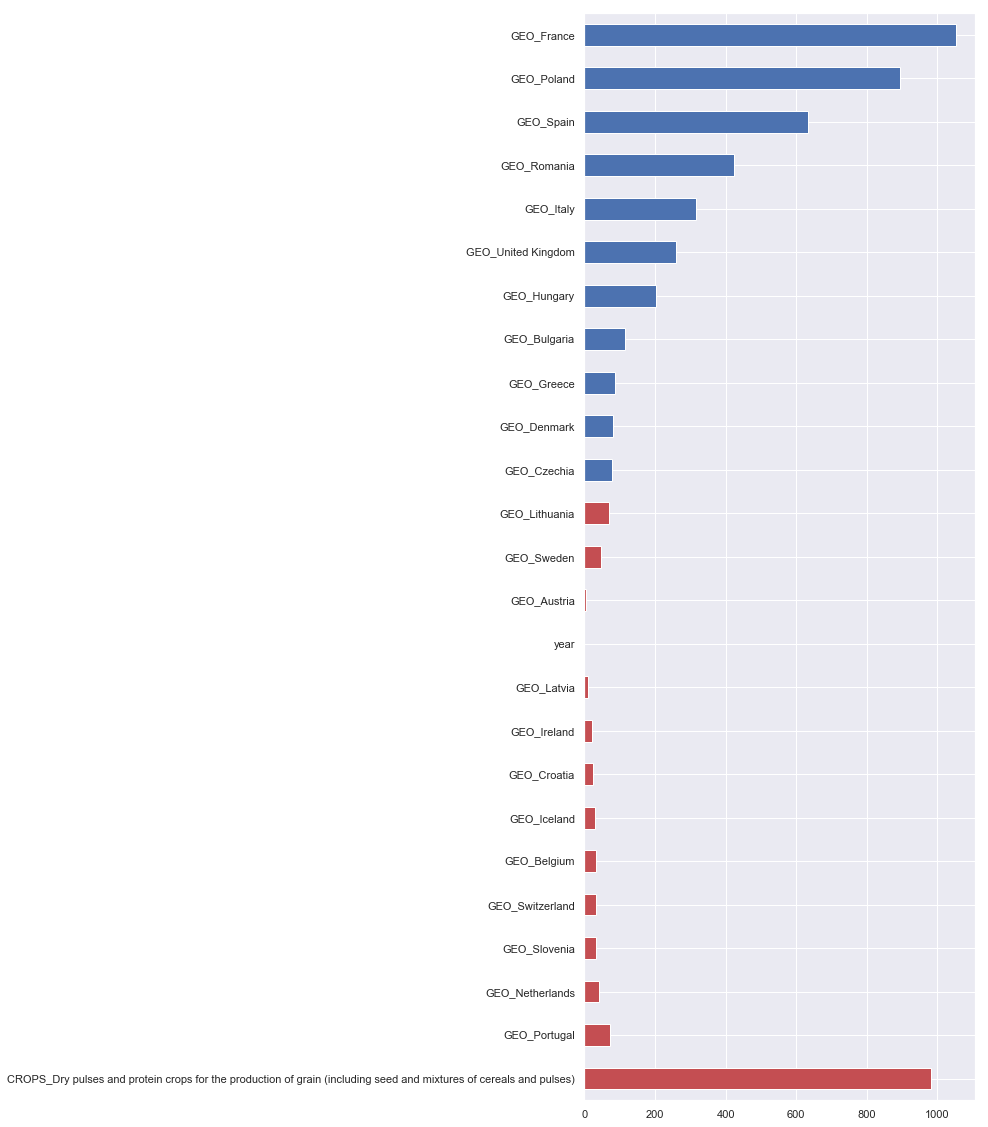

In [227]:
plt.figure(figsize=(7,20))

df_coef4.sort_values(by='coefficients').coef_abs.plot(kind='barh',color=colors);

In [203]:
m1 = df_coef4[df_coef4['coefficients'] < 0]
m2 = df_coef4[df_coef4['coefficients'] >= 0]

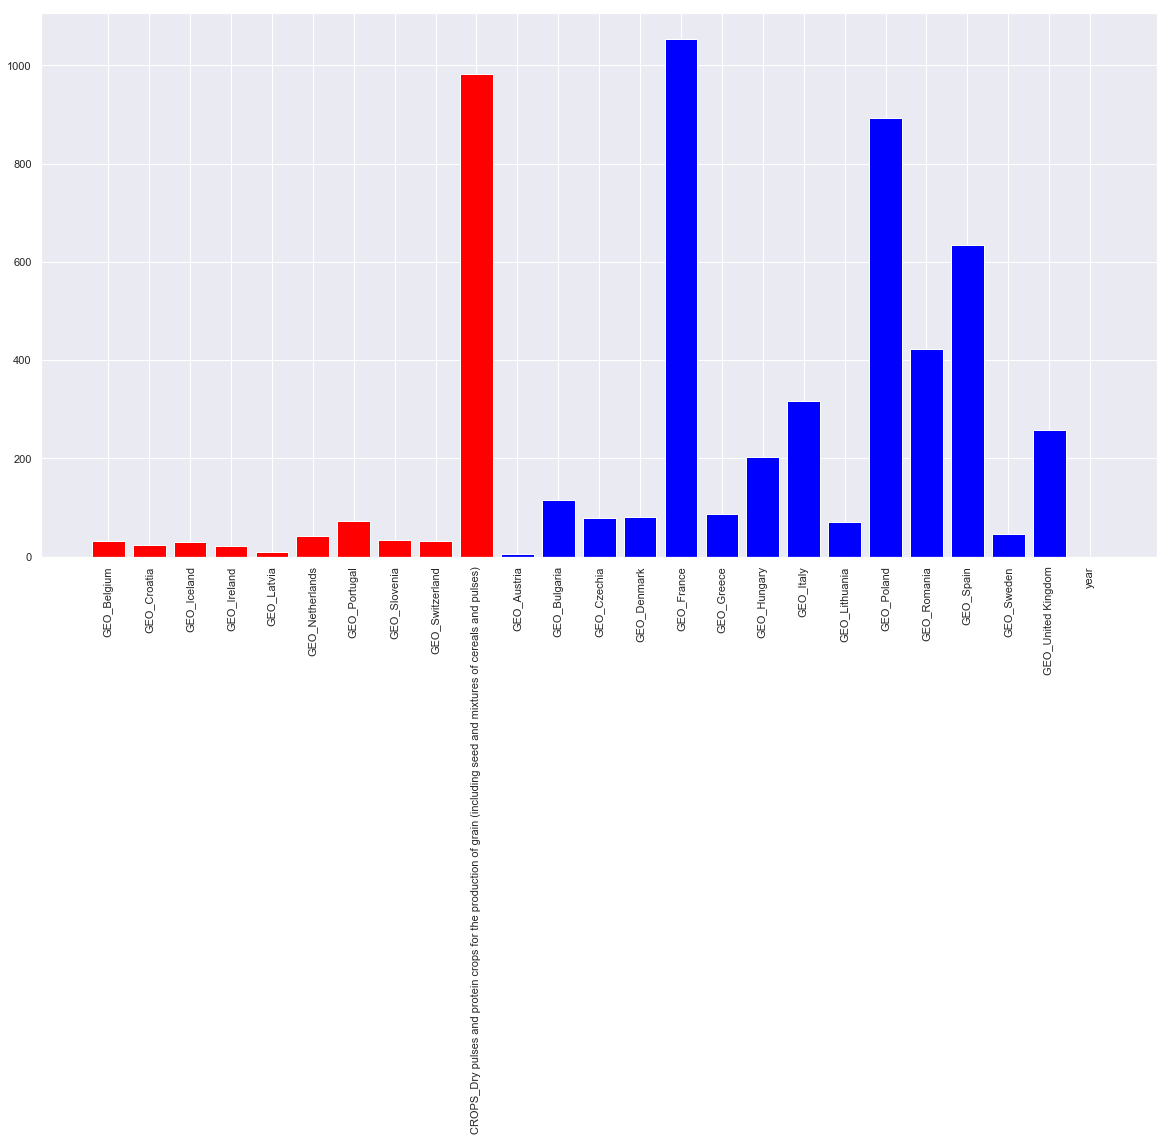

In [210]:
plt.figure(figsize=(20,10))

m1 = (df_coef4.coefficients < 0)
m2 = (df_coef4.coefficients >= 0)


x = df_coef4.index
y = df_coef4.coef_abs
plt.bar(x[m1], y[m1], color = 'red')
plt.bar(x[m2], y[m2], color = 'blue')
plt.xticks(rotation=90);
plt.show()

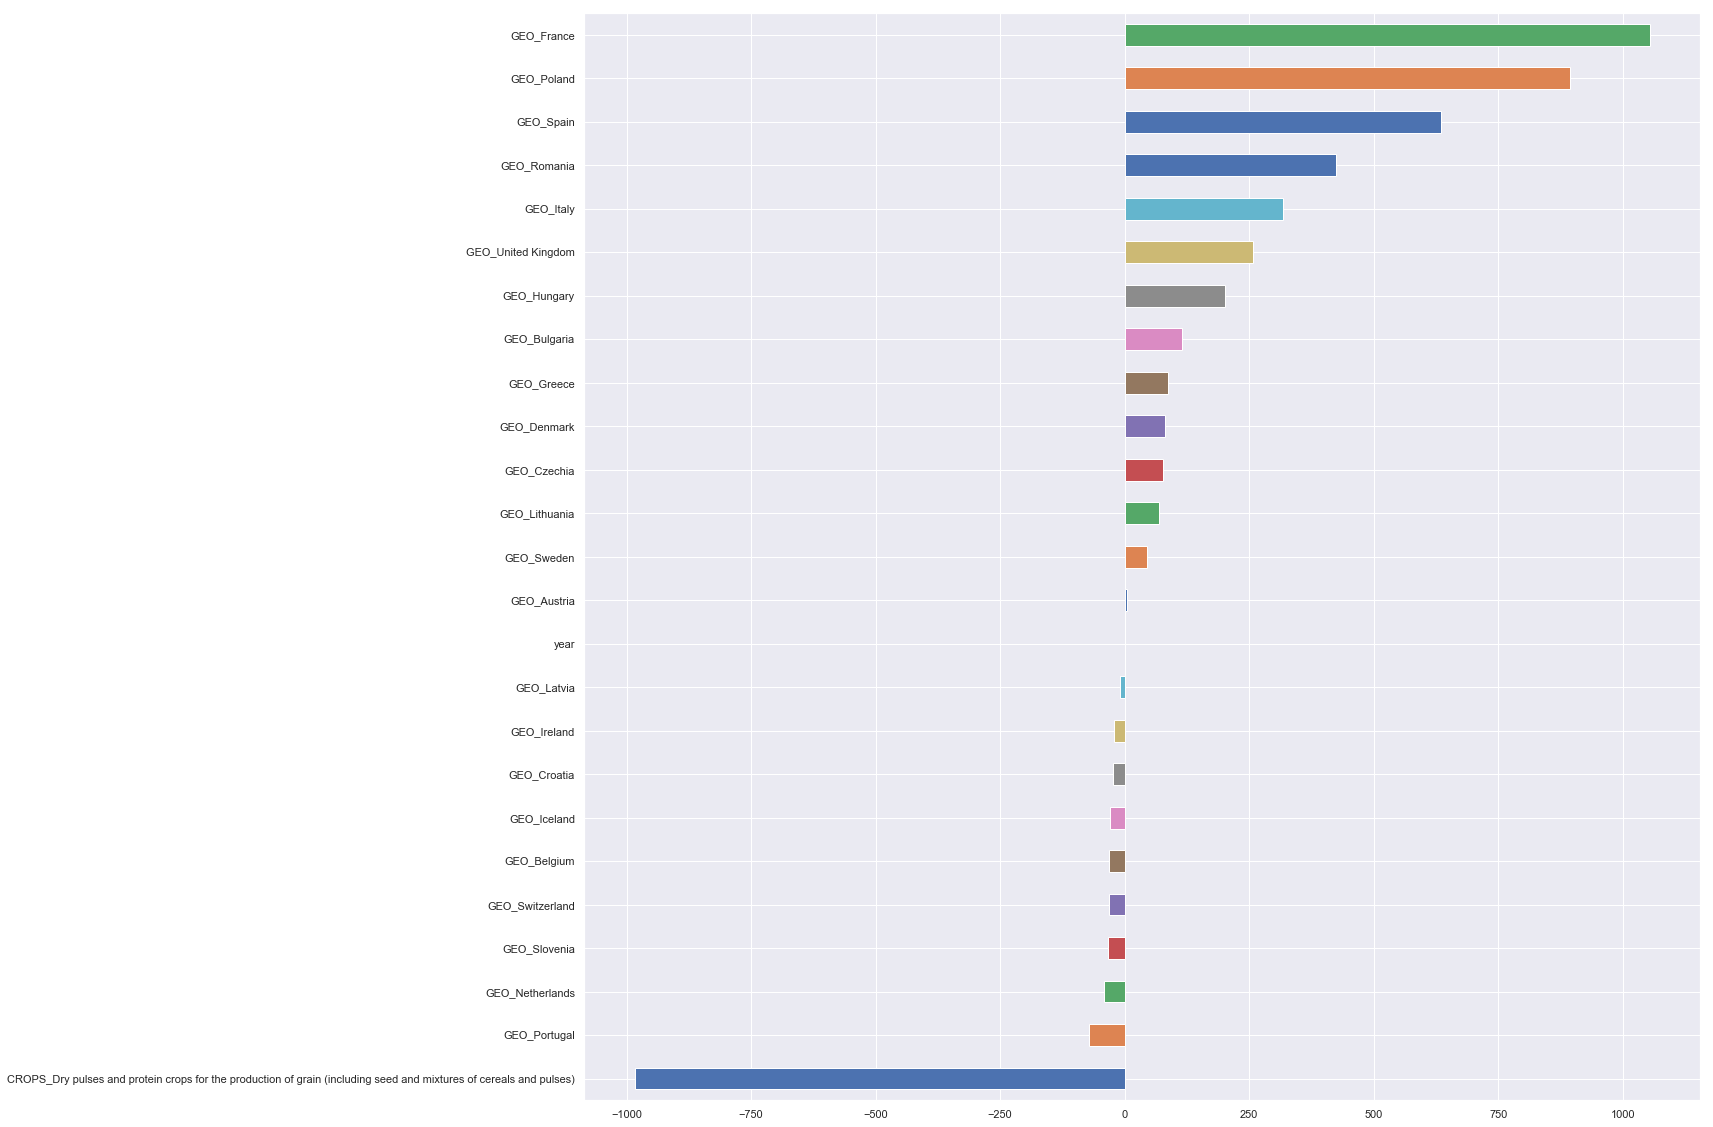

In [143]:
plt.figure(figsize=(20,20))

    
df_coef4['coefficients'].sort_values().plot(kind='barh');

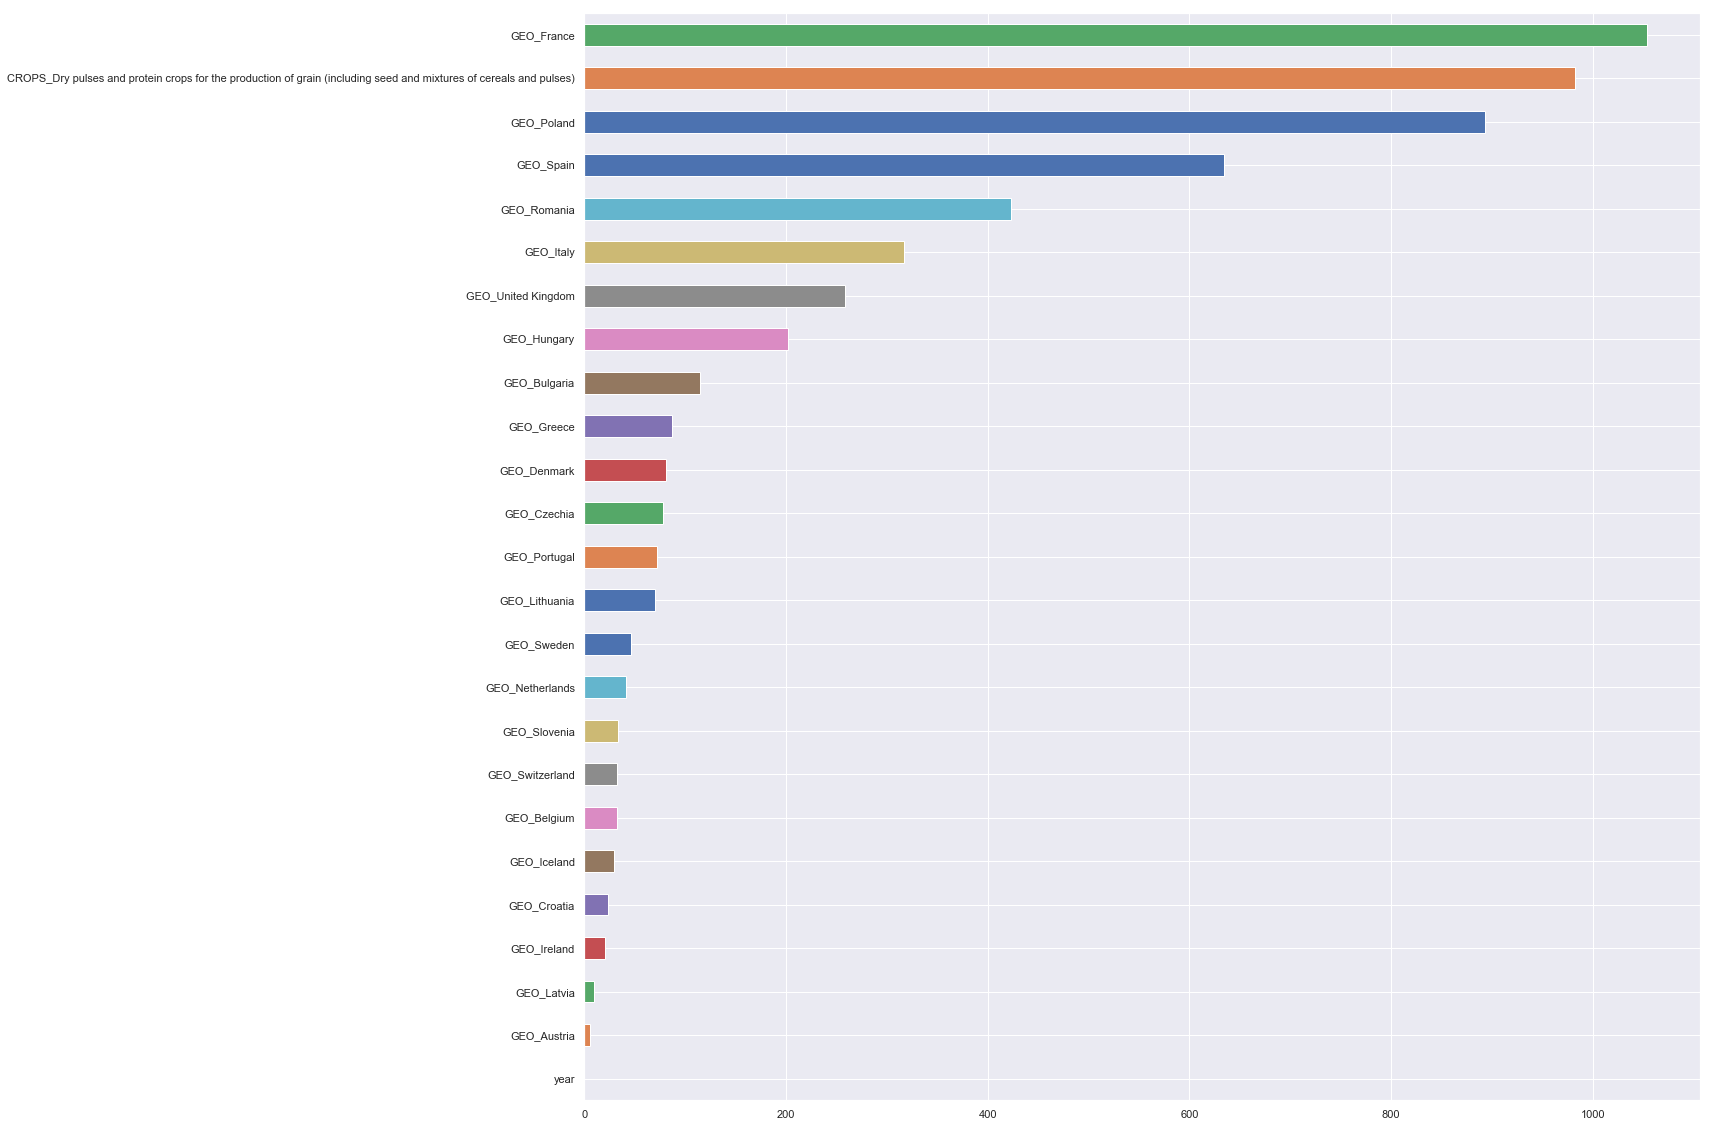

In [66]:
plt.figure(figsize=(20,20))
df_coef4['coef_abs'].sort_values().plot(kind='barh');

Can normalize by dividing by total sum  of coefficients.

### Decission tree and Random forest regression

In [67]:
dt = DecisionTreeRegressor()

In [68]:
get_model_scores(DecisionTreeRegressor(max_depth=5), X_train, y_train, X_test, y_test)

Cross-validated training scores: [0.92115477 0.91659738 0.91918998 0.89657478 0.87103778]
Mean cross-validated training score: 0.9049109385260639
Training Score: 0.9085643986719595
Test Score: 0.8942512229957943


DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [69]:
def plot_dt(dt, feature_names=None):
    print('Max depth:', dt.max_depth)
    dot_data = StringIO() 
    export_graphviz(dt, 
                    out_file=dot_data,  
                    filled=True, 
                    rounded=True,
                    special_characters=True,
                    feature_names=feature_names
                   )  

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    return Image(graph.create_png()) 

In [70]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Max depth: None


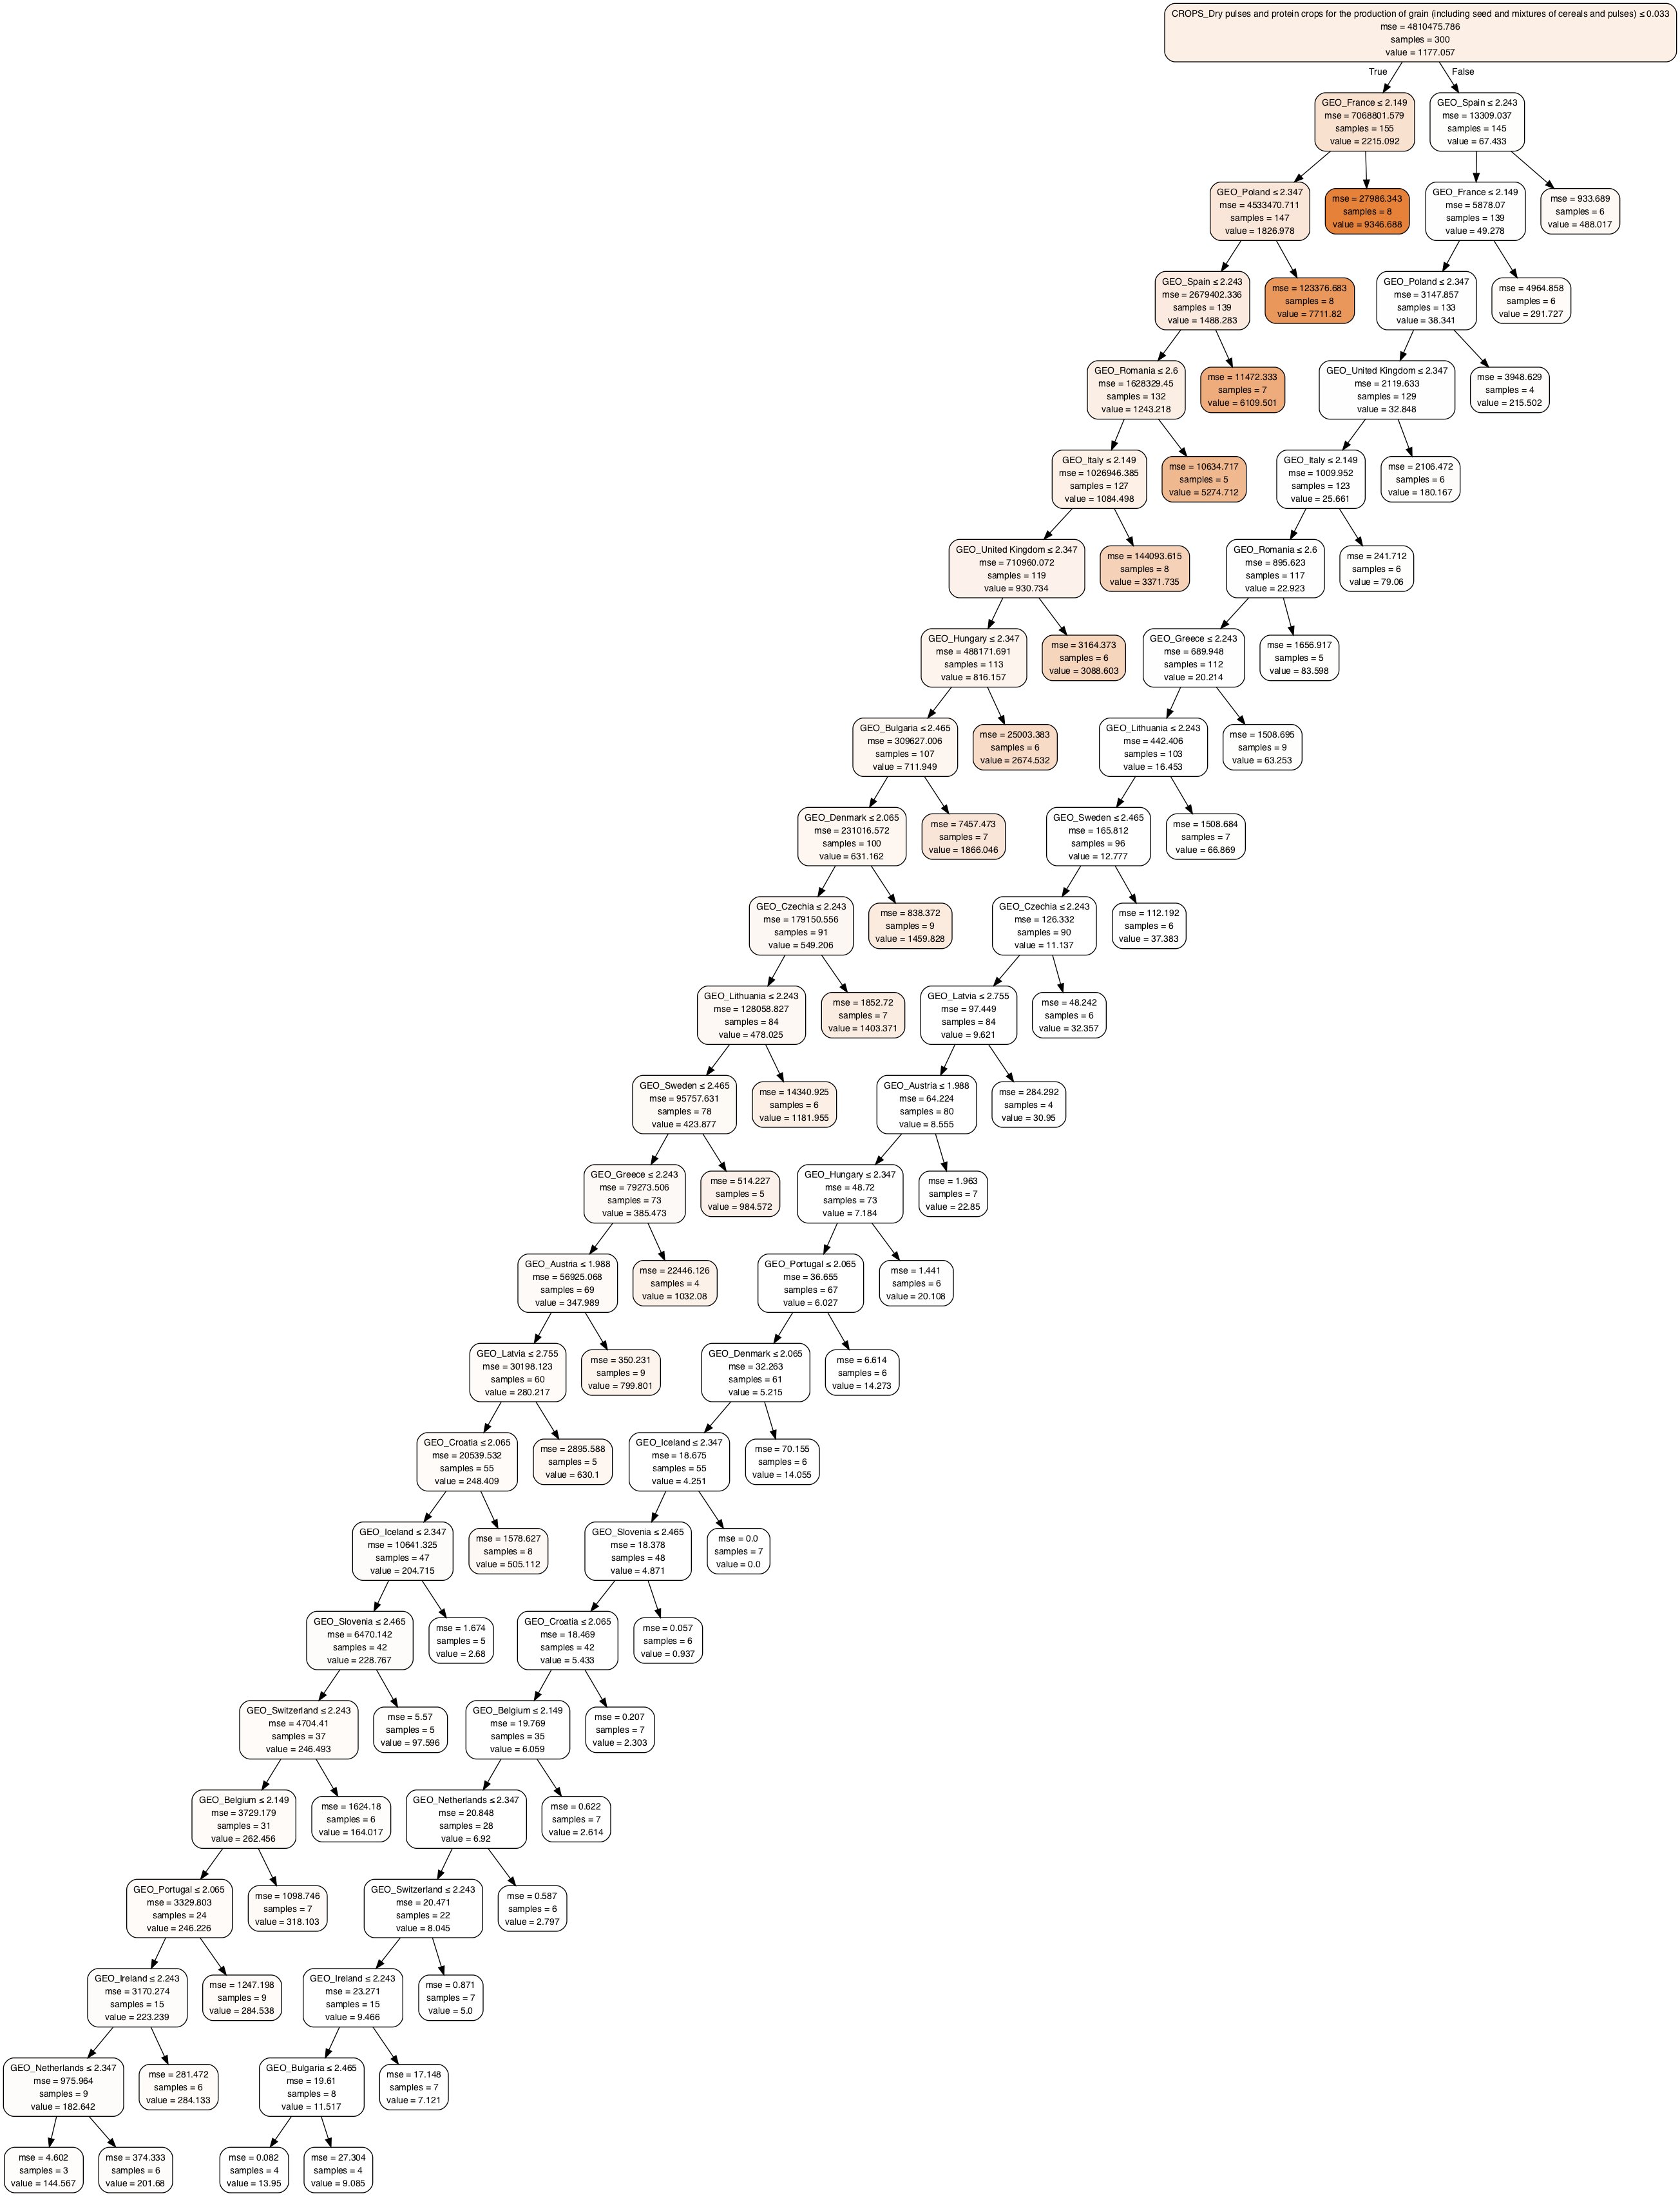

In [71]:
plot_dt(dt, feature_names=eur_X.columns)

In [72]:
kfolds = 5
model = DecisionTreeRegressor(random_state=1)

In [73]:
params = {'max_depth': [1, 2, 3, 4, 5, 6],
          #, 'max_features':[1,2,3,4],
          'max_leaf_nodes': [5, 6, 7, 8, 9, 10],
          'min_samples_leaf': [1, 2, 3, 4]
          #'min_samples_split':[1,2,3,4]
          }

gs = GridSearchCV(model, param_grid=params, cv=kfolds, n_jobs = -1)
gs.fit(X_train, y_train)

model = gs.best_estimator_
print(gs.best_estimator_)
print('R2 training: ', gs.score(X_train, y_train))
print('R2 test: ', gs.score(X_test, y_test))

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')
R2 training:  0.9597173757269921
R2 test:  0.9422018664143803


In [74]:
gs_mse = GridSearchCV(model, param_grid=params, cv=kfolds,
                      scoring='neg_mean_squared_error')
gs_mse.fit(X_train, y_train)

print(gs_mse.best_estimator_)
print('MSE training: ', -gs_mse.score(X_train, y_train))
print('MSE test: ', -gs_mse.score(X_test, y_test))

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')
MSE training:  193778.58865909855
MSE test:  187990.0866672007


In [75]:
np.sqrt(-gs_mse.score(X_train, y_train))

440.20289487814426

In [76]:
eur_y.mean(), eur_y.std()

(1088.876674107143, 2078.7506115265546)

## Feature Importance would be good.

In [77]:
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [78]:
df_coef = pd.DataFrame(dt.feature_importances_, index=X_train.columns,
                       columns=['feature importances'])
df_coef.sort_values('feature importances', ascending=False)

,feature importances
GEO_France,0.298174
CROPS_Dry pulses and protein crops for the production of grain (including seed and mixtures of cereals and pulses),0.239954
GEO_Poland,0.203551
GEO_Spain,0.110082
GEO_Romania,0.058666
GEO_Italy,0.031029
GEO_United Kingdom,0.020526
GEO_Hungary,0.015197
GEO_Bulgaria,0.006928
GEO_Denmark,0.004716


In [79]:
model = RandomForestRegressor(random_state=1)
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [80]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [81]:
df_coef5 = pd.DataFrame(model.feature_importances_, index=X_train.columns,
                       columns=['feature importances'])

In [82]:
df_coef_ = pd.DataFrame(lr.coef_, index=X_train.columns,
                       columns=['coefficients'])

In [83]:
df_coef5['coef_abs'] = df_coef_.coefficients.abs()

In [84]:
df_coef5.sort_values('feature importances', ascending = False)

,feature importances,coef_abs
CROPS_Dry pulses and protein crops for the production of grain (including seed and mixtures of cereals and pulses),0.283644,985.011442
GEO_France,0.253967,1078.764581
GEO_Poland,0.205682,915.875004
GEO_Spain,0.107160,657.329950
GEO_Romania,0.066519,443.097153
GEO_Italy,0.028481,339.391663
GEO_United Kingdom,0.019442,278.979690
GEO_Hungary,0.014094,222.726668
GEO_Bulgaria,0.006096,133.678626
GEO_Denmark,0.004637,103.237058


In [85]:
df_coef5.corr(method='spearman')

,feature importances,coef_abs
feature importances,1.000000,0.920769
coef_abs,0.920769,1.000000


### Random forest correlations

In [87]:
model_f = RandomForestRegressor(random_state=1)

In [88]:
model_f.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [89]:
df_coef_f = pd.DataFrame(model_f.feature_importances_, index=X_train.columns,
                       columns=['feature importances'])
df_coef_f['coef_abs'] = df_coef_.coefficients.abs()

In [90]:
df_coef_f.sort_values('feature importances', ascending = False)

,feature importances,coef_abs
CROPS_Dry pulses and protein crops for the production of grain (including seed and mixtures of cereals and pulses),0.283644,985.011442
GEO_France,0.253967,1078.764581
GEO_Poland,0.205682,915.875004
GEO_Spain,0.107160,657.329950
GEO_Romania,0.066519,443.097153
GEO_Italy,0.028481,339.391663
GEO_United Kingdom,0.019442,278.979690
GEO_Hungary,0.014094,222.726668
GEO_Bulgaria,0.006096,133.678626
GEO_Denmark,0.004637,103.237058


In [91]:
df_coef_f.corr(method='spearman')

,feature importances,coef_abs
feature importances,1.000000,0.920769
coef_abs,0.920769,1.000000


In [92]:
df_f = df_coef_f[df_coef_f['feature importances'] > 0.004]

In [93]:
df_f.sort_values('feature importances', ascending = False)

,feature importances,coef_abs
CROPS_Dry pulses and protein crops for the production of grain (including seed and mixtures of cereals and pulses),0.283644,985.011442
GEO_France,0.253967,1078.764581
GEO_Poland,0.205682,915.875004
GEO_Spain,0.107160,657.329950
GEO_Romania,0.066519,443.097153
GEO_Italy,0.028481,339.391663
GEO_United Kingdom,0.019442,278.979690
GEO_Hungary,0.014094,222.726668
GEO_Bulgaria,0.006096,133.678626
GEO_Denmark,0.004637,103.237058


In [94]:
df_f.corr(method='spearman')

,feature importances,coef_abs
feature importances,1.000000,0.987879
coef_abs,0.987879,1.000000


### SUPPOOOOORT Vectors

In [95]:
model_lin = LinearSVR() 
model_rbf = SVR(kernel='rbf', gamma='scale')

In [99]:
predictions = get_model_scores(model_lin, X_train, y_train, X_test, y_test)


Cross-validated training scores: [-0.18214003 -0.13916462 -0.1606712  -0.10159416 -0.3107809 ]
Mean cross-validated training score: -0.17887018356029052
Training Score: -0.14802972833680705
Test Score: -0.10861940074527456


In [100]:
predictions = get_model_scores(model_rbf, X_train, y_train, X_test, y_test)

Cross-validated training scores: [-0.19462703 -0.15744562 -0.19396897 -0.11952169 -0.34496059]
Mean cross-validated training score: -0.20210477778971203
Training Score: -0.19203958819078923
Test Score: -0.1486961625916936


In [102]:
from sklearn import metrics


In [103]:
def grid_search_func(estimator, params, X_train, y_train, X_test, y_test, scoring_function=metrics.r2_score, scoring='r2', cv=5):
    gs = GridSearchCV(
        estimator=estimator,
        param_grid=params,
        return_train_score=True,
        scoring=scoring,
        cv=cv,
        iid=False)

    gs.fit(X_train, y_train)

    print("Best score")
    print(gs.best_score_)
    print()
    print("Best estimator")
    print(gs.best_estimator_.get_params())
    print()

    predictions = gs.best_estimator_.predict(X_test)
    print('Test score: ', scoring_function(y_test, predictions))


    return gs

In [106]:
params_lin = {
    'C': np.logspace(-2, 2, 3),
    'loss': ['epsilon_insensitive','squared_epsilon_insensitive'],
    'fit_intercept': [True],
    'max_iter': [10000]
}

gs_lin = grid_search_func(model_lin, params_lin,
                          X_train, y_train, X_test, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best score
0.6454322303790325

Best estimator
{'C': 1.0, 'dual': True, 'epsilon': 0.0, 'fit_intercept': True, 'intercept_scaling': 1.0, 'loss': 'squared_epsilon_insensitive', 'max_iter': 10000, 'random_state': None, 'tol': 0.0001, 'verbose': 0}

Test score:  0.47588275368906385


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [118]:
params_rbf = {
    'C': np.logspace(-2, 2, 3),
    'gamma': np.logspace(-2, 2, 3),
    'kernel': ['rbf']
}

gs_rbf = grid_search_func(model_rbf,params_rbf,X_train,y_train,X_test,y_test)

Best score
0.05556557496760441

Best estimator
{'C': 100.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 100.0, 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Test score:  0.19320349886774113


In [107]:
lm = LinearRegression()
lasso = Lasso()
ridge = Ridge()

In [109]:
predictions = get_model_scores(lm, X_train, y_train, X_test, y_test)


Cross-validated training scores: [0.66554813 0.7035541  0.52640665 0.59756232 0.73330011]
Mean cross-validated training score: 0.6452742609749604
Training Score: 0.6953999523823395
Test Score: 0.47496335781539867


In [110]:
predictions = get_model_scores(lasso, X_train, y_train, X_test, y_test)


Cross-validated training scores: [0.66546039 0.70384011 0.52707763 0.59933915 0.73276363]
Mean cross-validated training score: 0.6456961812774281
Training Score: 0.6953843272034681
Test Score: 0.47548049119839597


In [111]:
predictions = get_model_scores(ridge, X_train, y_train, X_test, y_test)

Cross-validated training scores: [0.66500791 0.70287882 0.5278822  0.59969116 0.73197383]
Mean cross-validated training score: 0.6454867833387687
Training Score: 0.695331266502325
Test Score: 0.4761954046449851


In [113]:
params_ridge = {'alpha': np.logspace(-10, 10, 21),
          'fit_intercept': [True, False]}

gs_ridge = grid_search_func(ridge, params_ridge,
                          X_train, y_train, X_test, y_test)

Best score
0.6454867833387687

Best estimator
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}

Test score:  0.4761954046449851


In [114]:
params_lasso = {'alpha': np.logspace(-5, 10, 21),
                'fit_intercept': [True, False],
                'max_iter': [100000]}

gs_lasso = grid_search_func(lasso, params_lasso,
                          X_train, y_train, X_test, y_test)

Best score
0.6458934491522192

Best estimator
{'alpha': 1.7782794100389228, 'copy_X': True, 'fit_intercept': True, 'max_iter': 100000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}

Test score:  0.4758469125441396


In [115]:
gs_results = pd.DataFrame(gs_ridge.cv_results_)
gs_lasso_results = pd.DataFrame(gs_lasso.cv_results_)

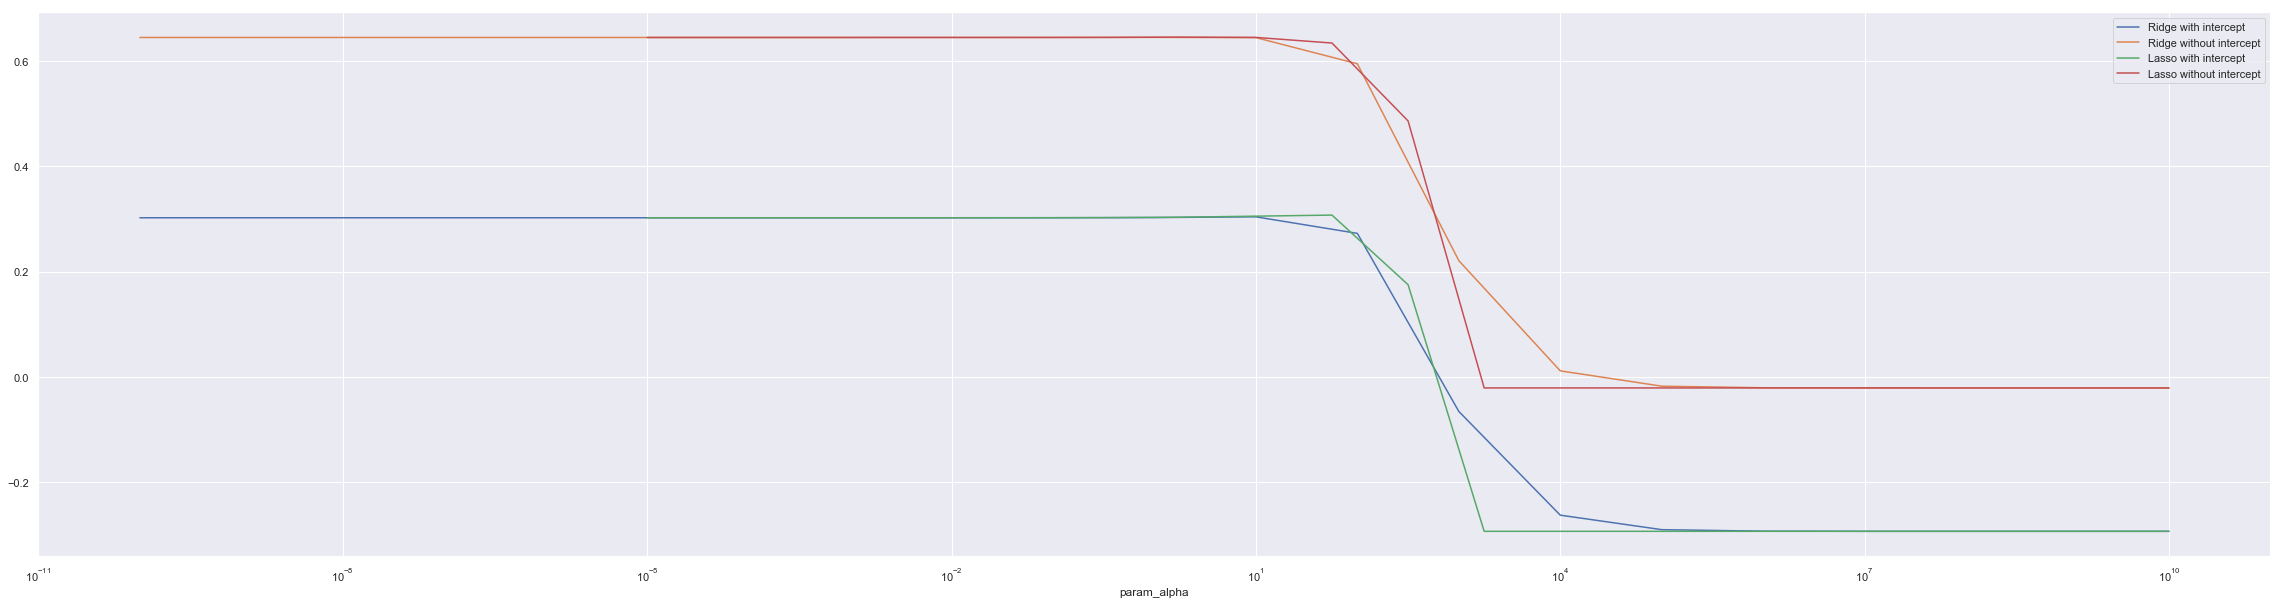

In [116]:
fig, ax = plt.subplots()
gs_results.groupby('param_fit_intercept').plot(
    x='param_alpha',
    y='mean_test_score',
    logx=True,
    ax=ax)
gs_lasso_results.groupby('param_fit_intercept').plot(
    x='param_alpha',
    y='mean_test_score',
    logx=True,
    ax=ax)
ax.legend(['Ridge with intercept','Ridge without intercept',
           'Lasso with intercept','Lasso without intercept'])
plt.show()